# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [4]:
input_filename = 'data/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [5]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data


C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 12439, '#non-significant genes': 8969, '#silent genes': 11490, 'ell': 64, 'Elapsed time': '0h 1m 4s 856ms', 'solver': 'randomized', '#test_data': 2297}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [6]:
adata

AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance_RECODE', 'normalized_variance_RECODE', 'significance_RECODE'
    layers: 'RECODE'

## Performance verification
### Show report:

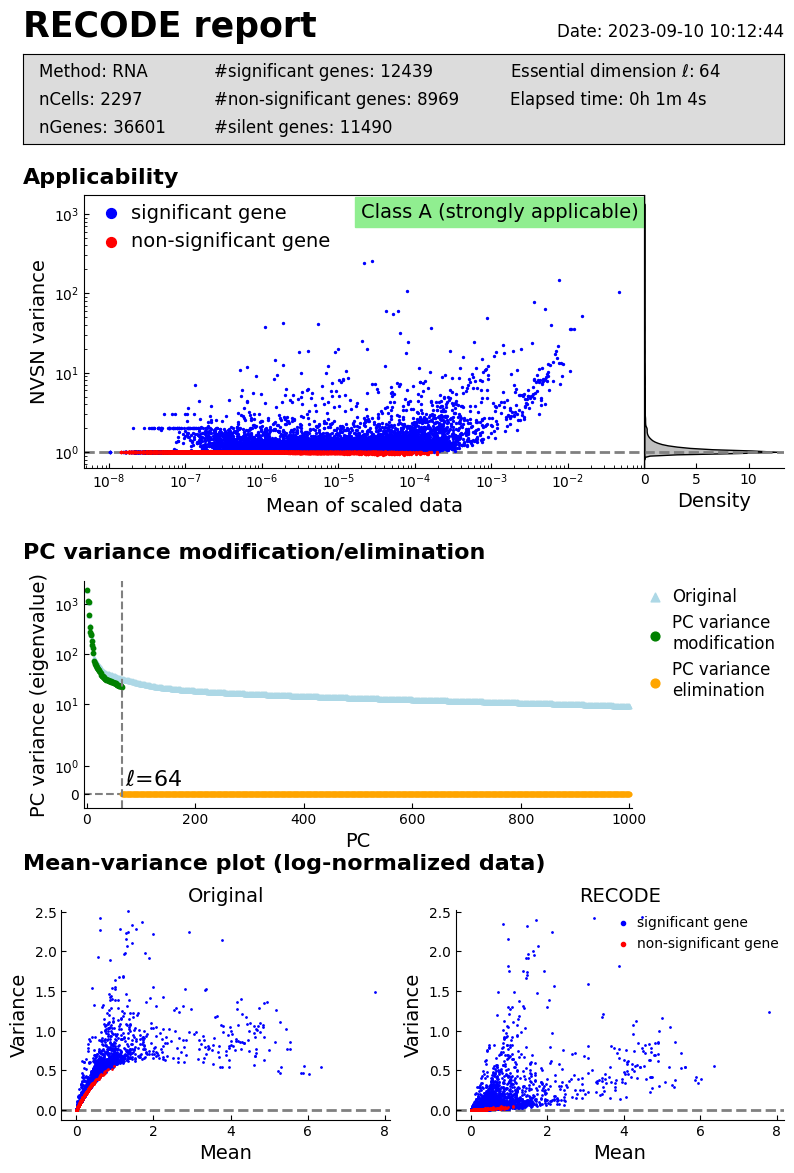

In [7]:
recode.report()

# Downstream analysis based on [scanpy](https://scanpy.readthedocs.io/en/stable/index.html)

In [10]:
import numpy as np
import scanpy as sc
adata.layers["Raw"] = adata.X.toarray()

## log normalization

In [11]:
adata.X = adata.layers["RECODE"]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## PCA

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

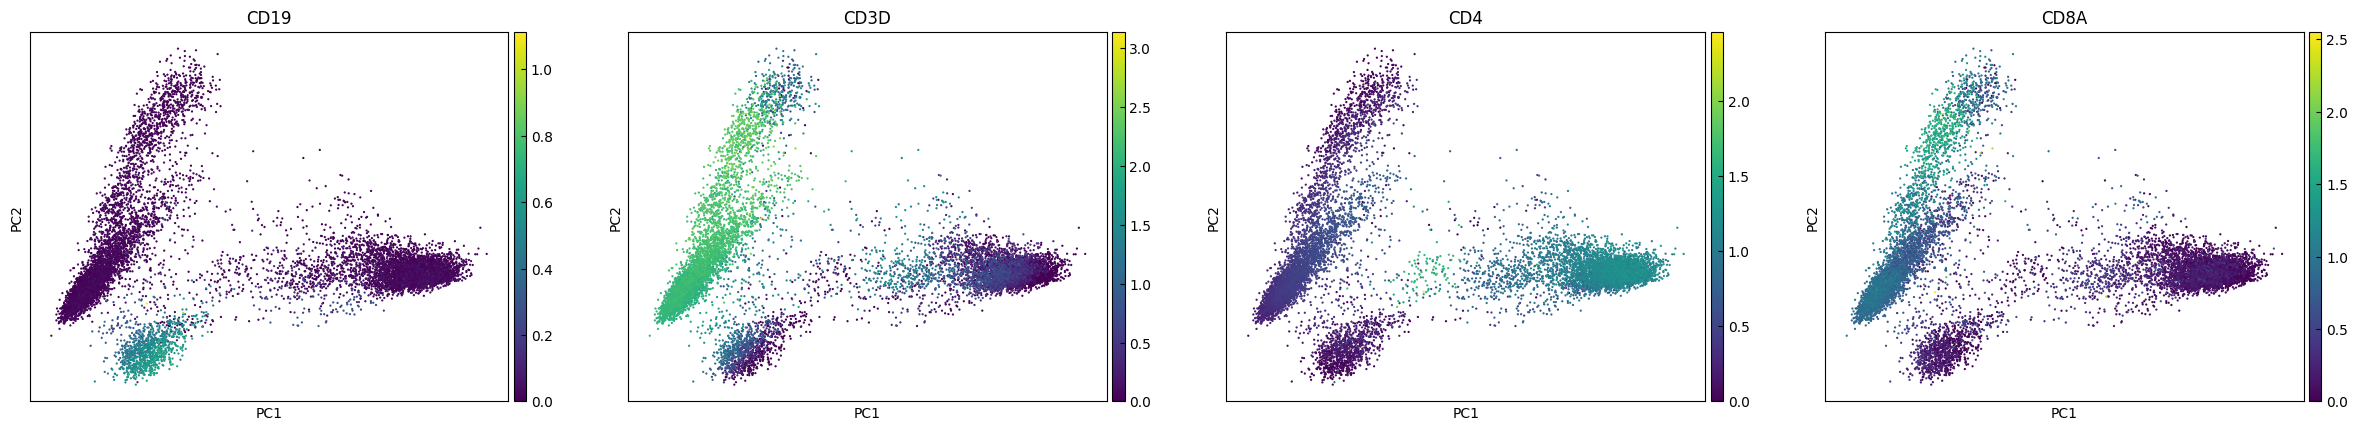

In [17]:
plot_genes = ['CD19','CD3D','CD4','CD8A']
sc.pl.pca(adata, color=plot_genes)

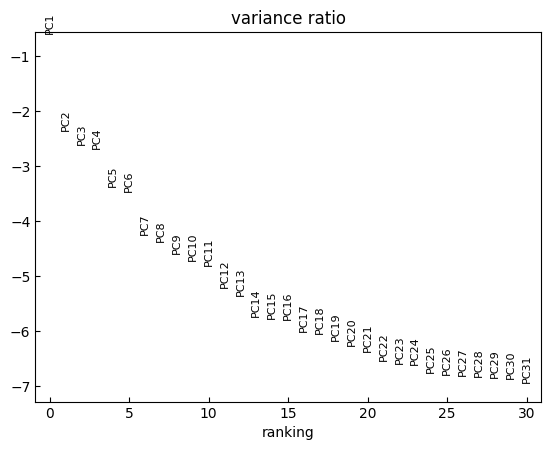

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

## UMAP

Note that we do not use the PCA dimentionaly reduction as a preprocessing of UMAP (`n_pca=0`). 

In [16]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=0)
sc.tl.umap(adata)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecatio

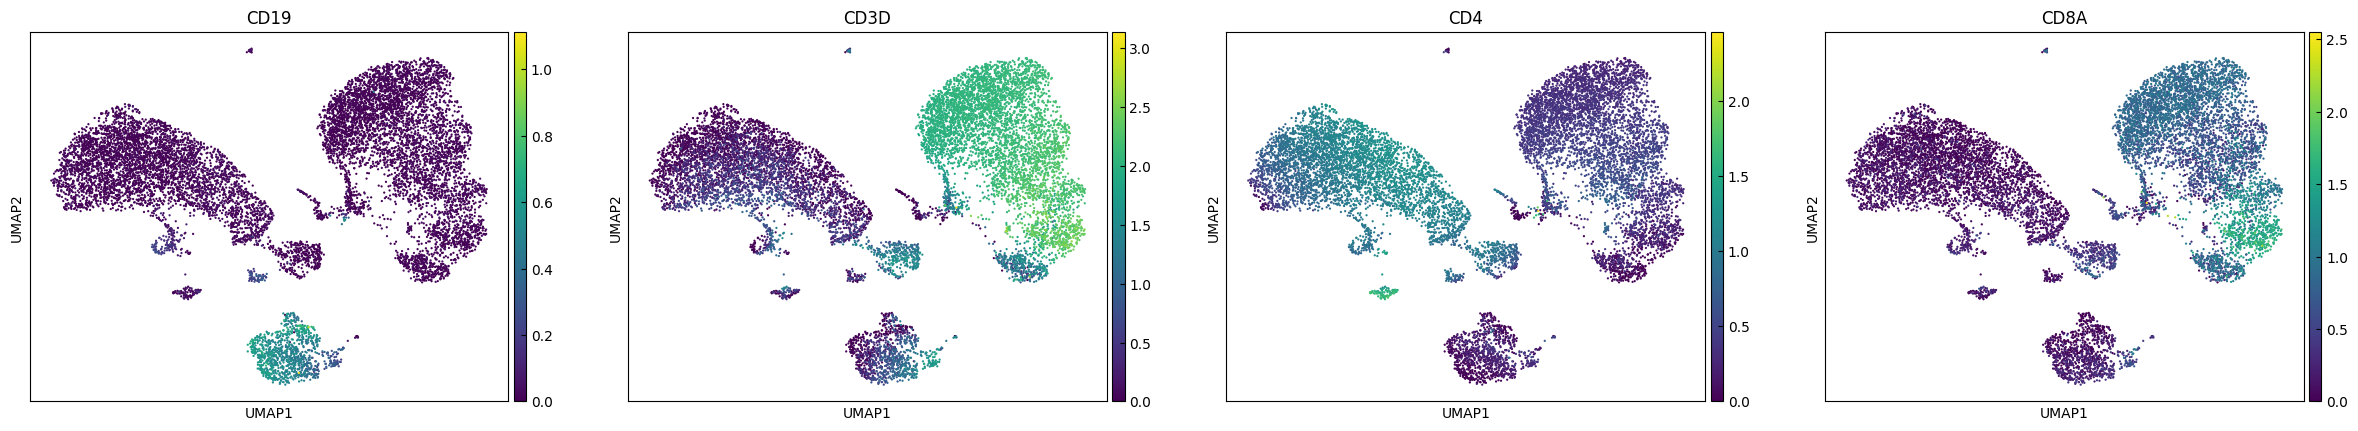

In [19]:
sc.pl.umap(adata, color=plot_genes)

## Clustering

In [20]:
sc.tl.leiden(adata)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


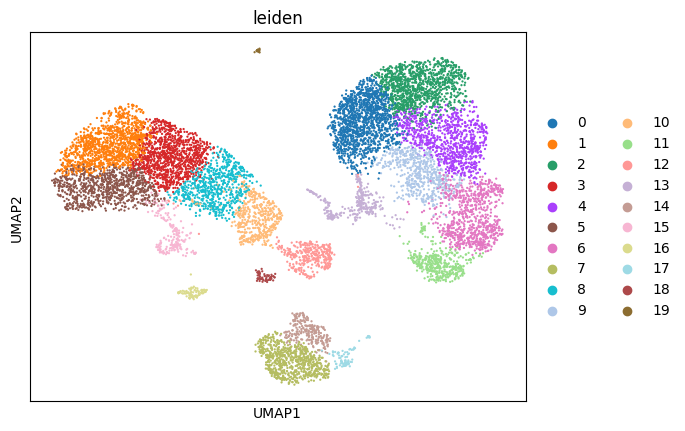

In [24]:
sc.pl.umap(adata, color=['leiden'])

## Find marker genes

In [27]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [47]:
marker_genes = list(adata.uns['rank_genes_groups']['names'][0]) # The top marker genes for each cluster

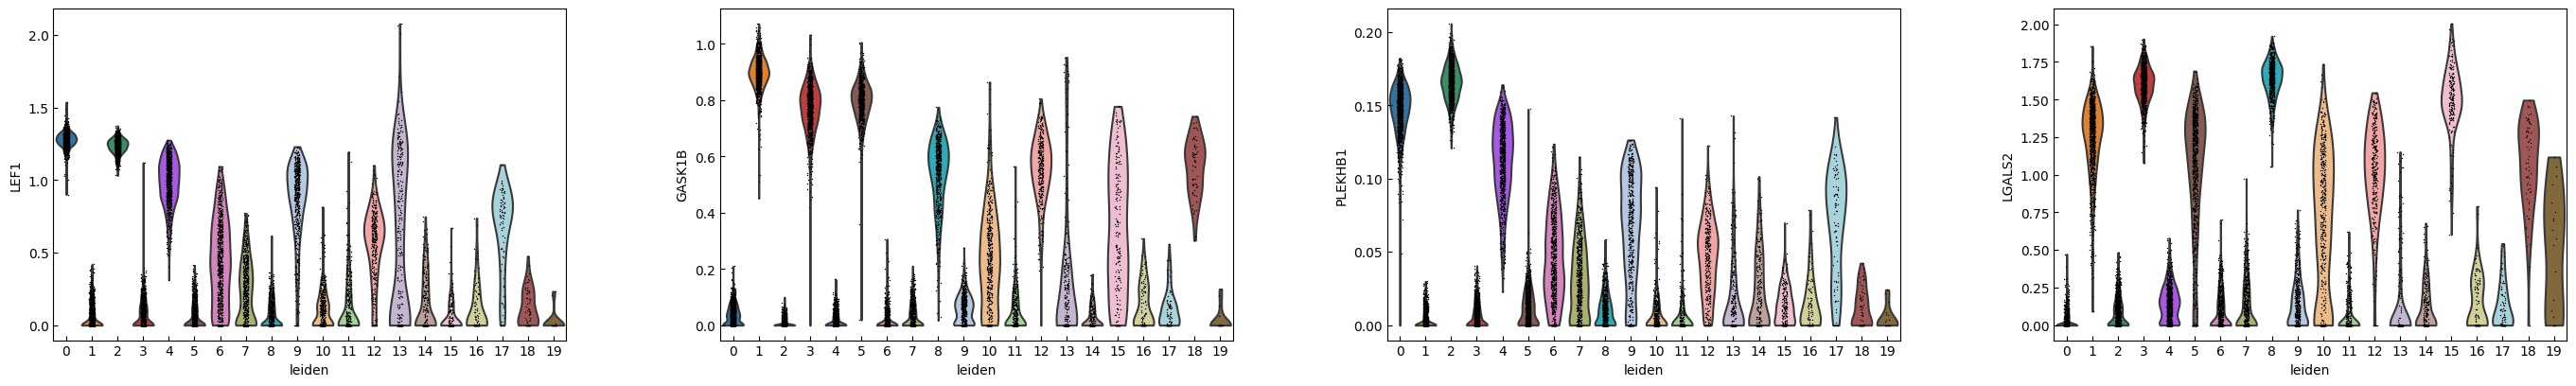

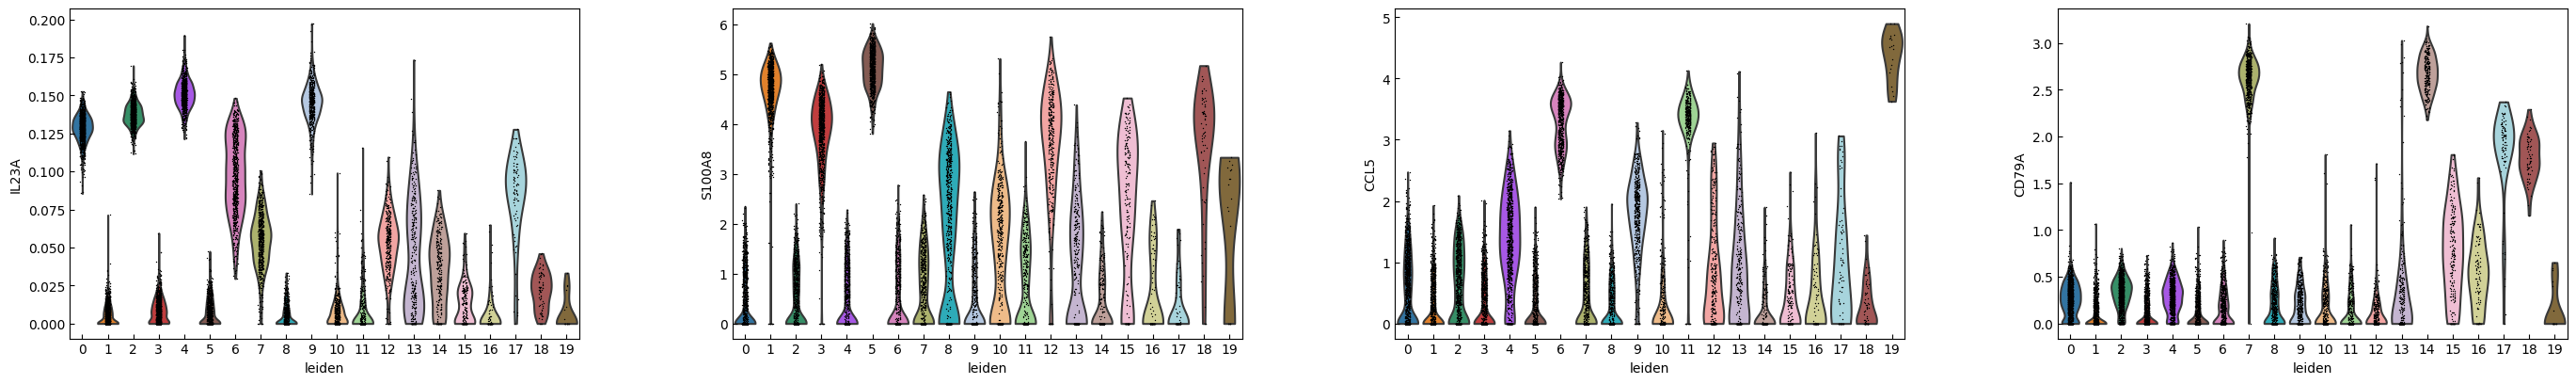

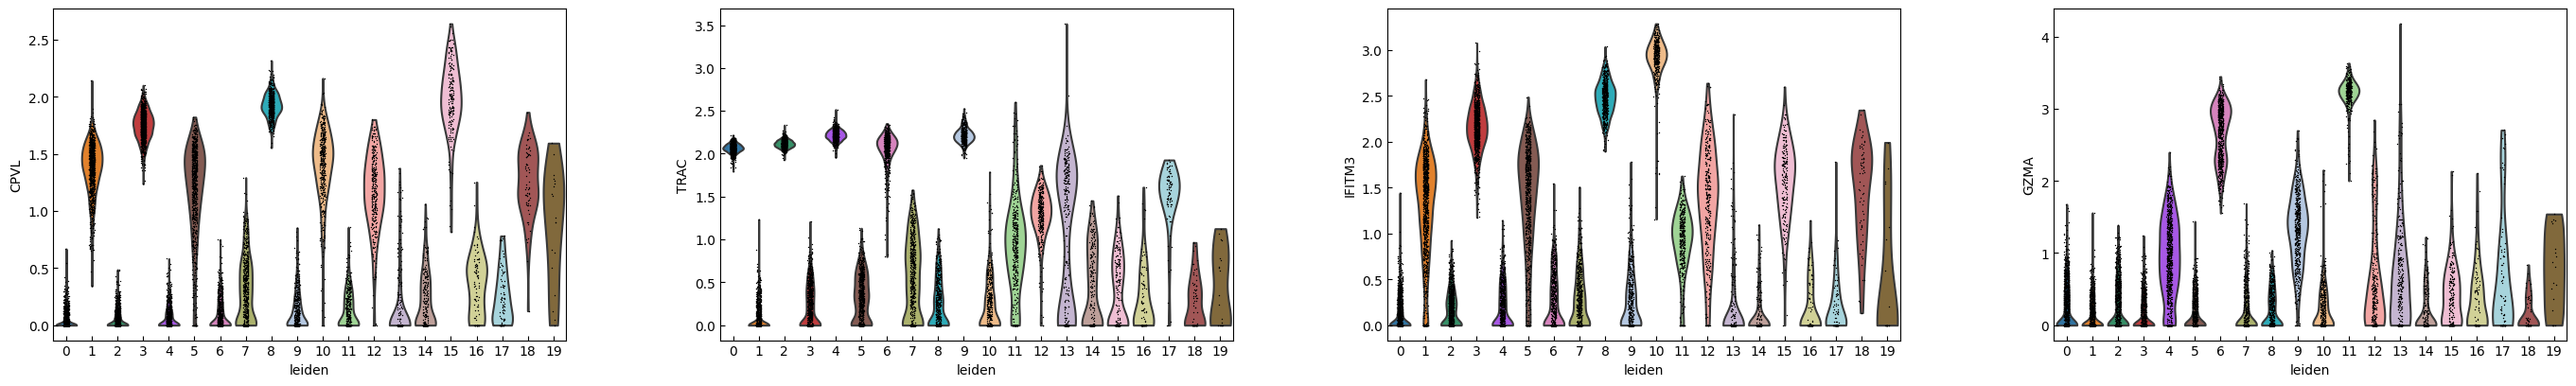

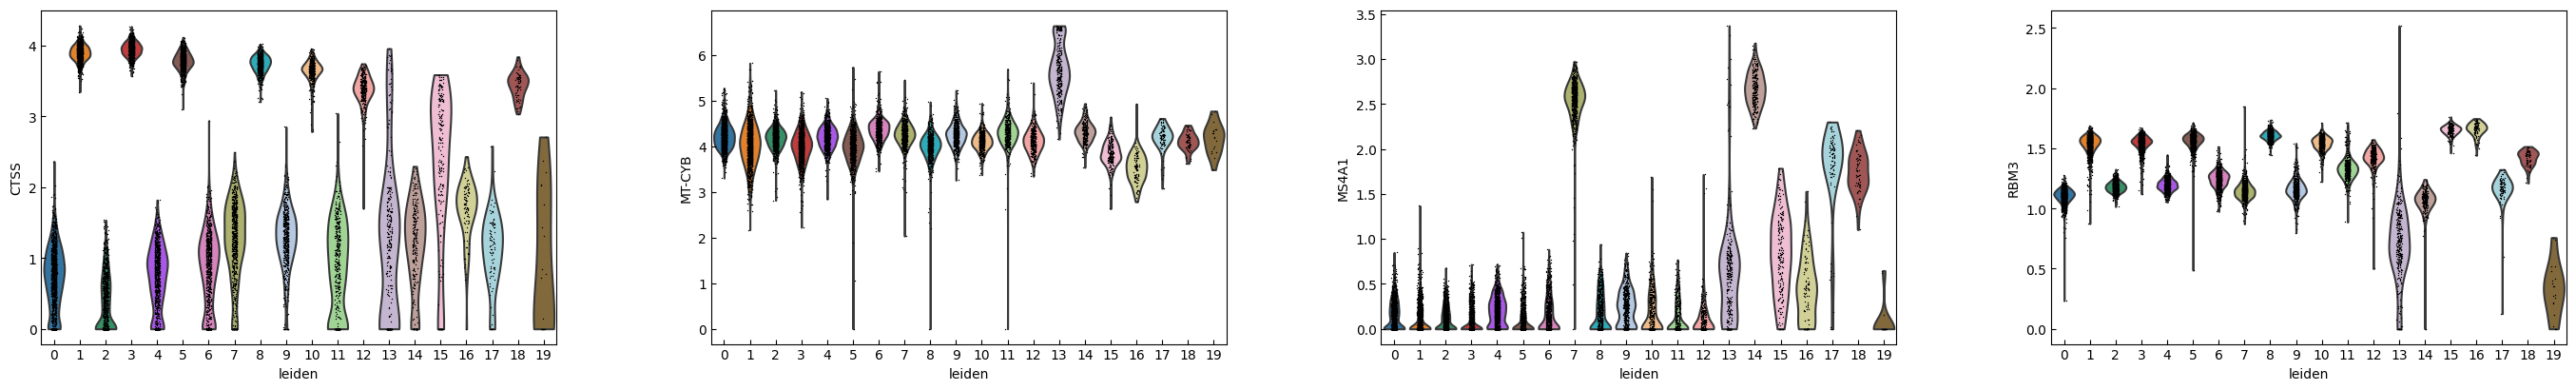

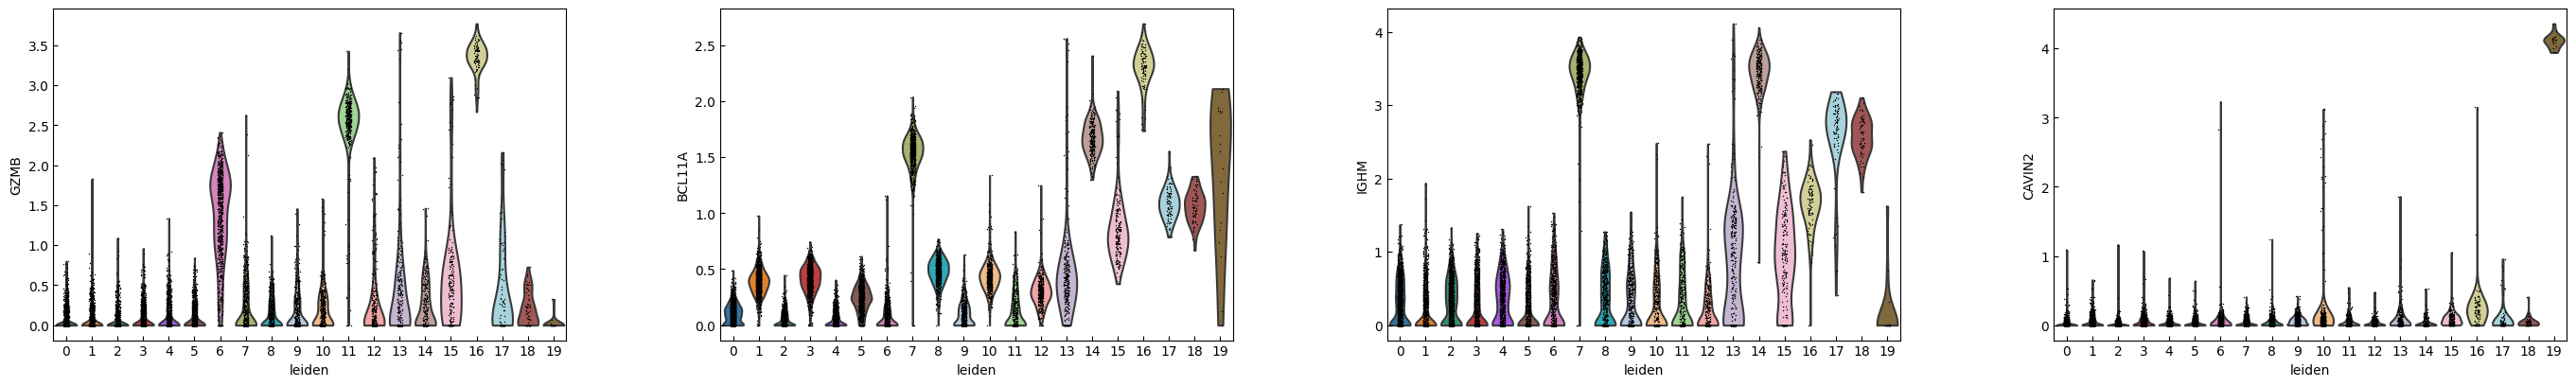

In [46]:
adata.var_names_make_unique()
n_cols = 4
for i in range(0, len(marker_genes),n_cols):
    sc.pl.violin(adata, marker_genes[i:i+n_cols], groupby='leiden')

## Gene expression distributions

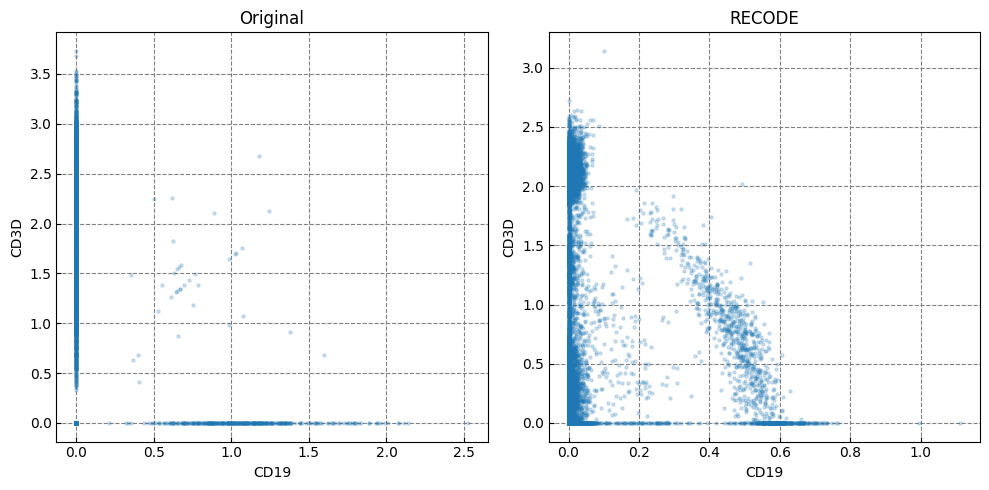

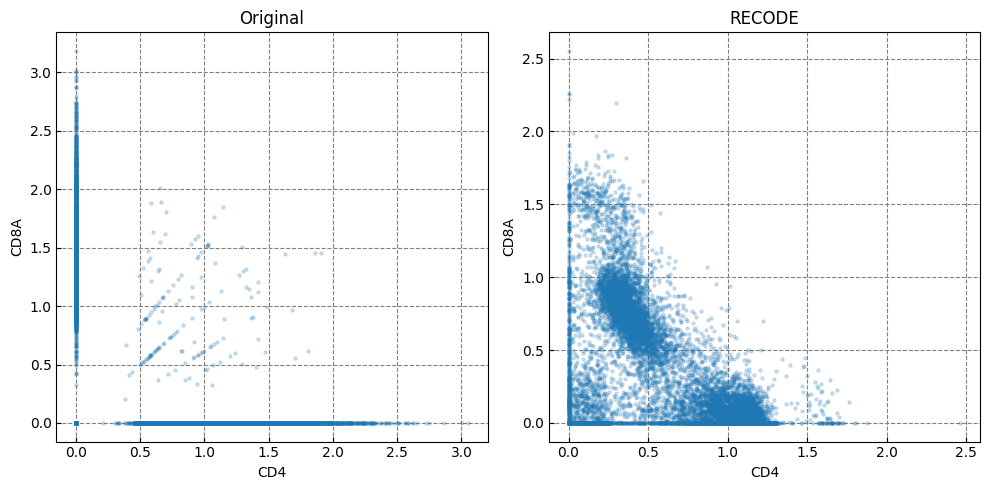

In [36]:
import matplotlib.pyplot as plt


size_factor = 1e4
alpha = 0.2
ps = 5
# plot_data = [np.log(size_factor*adata.layers['Raw'].T/np.sum(adata.layers['Raw'],axis=1)+1).T,
#             np.log(size_factor*adata.layers['RECODE'].T/np.sum(adata.layers['RECODE'],axis=1)+1).T]
plot_data = [np.log(size_factor*adata.layers['Raw'].T/np.sum(adata.layers['Raw'],axis=1)+1).T,
            adata.X]
names = ['Original','RECODE']

def plot_scatter(plot_data,names,genes):
    n_ax = len(plot_data)
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_ax):
        ax[i].scatter(plot_data[i][:,adata.var.index==genes[0]], plot_data[i][:,adata.var.index==genes[1]], alpha=alpha,zorder=10,s=ps)
        ax[i].set_xlabel(genes[0])
        ax[i].set_ylabel(genes[1])
        ax[i].set_title(names[i])
        ax[i].grid(ls='--',color='gray',zorder=0)

plot_scatter(plot_data,names,genes = ['CD19','CD3D'])
plot_scatter(plot_data,names,genes = ['CD4','CD8A'])